# Synthetic Cube Prototype

The following prototype uses a simple synthetic dataset, consisting of masks of a cube from varying angles, to test the basic function of the architecture, along with some tests for robustness against noise and occlusion.

In [1]:
import numpy as np

import torch
import torch.utils.data

import datasets
import metaimage
import nnet
import voxgrid
import display

%load_ext autoreload
%autoreload 2

## Dataset generation

The dataset used for this prototype is a synthetic dataset consisting of masks a 16x16x16 cube centered in a 32x32x32 space, with the masks generated from random angles around the cube.

This is intended as a simple test to identify if a basic, consistent 3D shape can be recovered from a collection of masks.

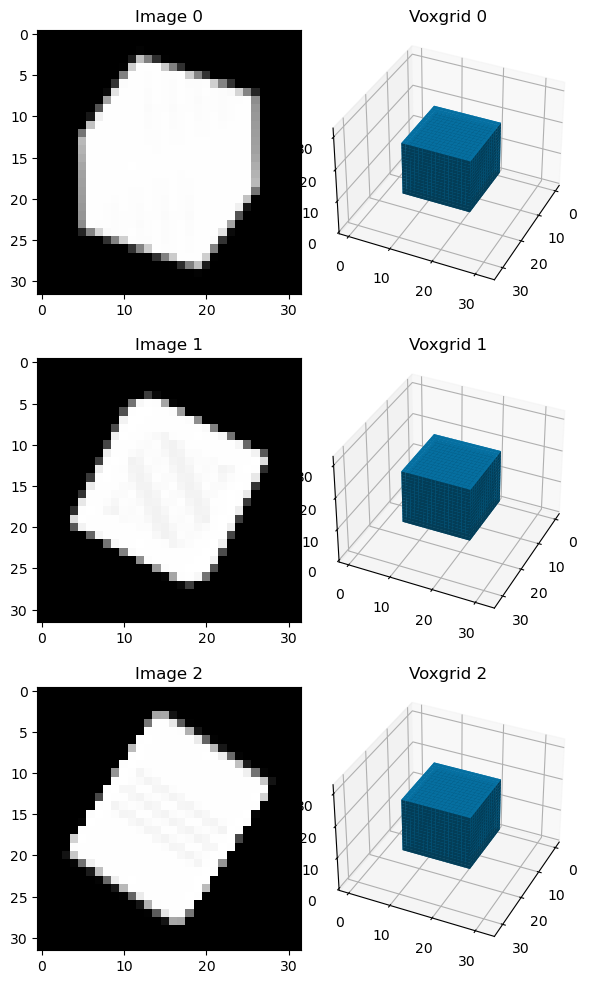

In [2]:
SIDE_RANGE = (16, 16)
IMAGE_SIZE = (32, 32)
SPACE_SIZE = (32, 32, 32)
BATCH_SIZE = 100

train_dataset_0_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 1000, train=True)
val_dataset_0_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 100)

train_loader_0_noise = torch.utils.data.DataLoader(
    train_dataset_0_noise, batch_size=BATCH_SIZE, shuffle=True
)
val_loader_0_noise = torch.utils.data.DataLoader(val_dataset_0_noise, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            metaimage.Mask(train_dataset_0_noise[i][0], title=f"Image {i}"),
            voxgrid.VoxGrid(train_dataset_0_noise[i][1][1], title=f"Voxgrid {i}"),
        ]
        for i in range(3)
    ],
    figsize=(6, 10),
)
display.show()

## Architecture

There are three elements in the architecture:
- The generator, which takes an input of a latent vector and creates a voxel grid of the desired size.
- The renderer, which takes in the voxel grid and creates a 2D image of the object viewed from a random angle.
- The discriminator, which takes in real and generated images and determines whether they are real.

These are setup as a GAN for training.

The primary goal is to train the generator to consistently recreate the voxel grid model that was used to create the training images.

### Generator

The generator is a 3D convolutional network. The latent space is mapped linearly to a 192x2x2x2 tensor. This is then repeatedly upsampled using an upsampling block followed by a 5x5 convolution. This doubles the dimensions and halves the number of channels at each stage, to reach a 12x32x32x32 tensor. In the penultimate layer, there is a additionally a ResNet block to give the model additional expressivity. A final convolutional layer is used produce a 1x32x32x32 tensor.

### Renderer

The renderer takes in the 1x32x32x32 tensor and creates an image of it that is 1x32x32. 

### Discriminator

The discriminator is a 2D resnet. This takes in a 32x32 mask, passes it through a resnet block and downsample using a strided convolution, halving the dimensions and doubling the number of channels at each stage. This is until a 4x4 mask is produced, which is then flattened and passed through a linear layer to produce a single label indicating the probability that the mask is real.

In [18]:
LATENT_SIZE = 64
BASE_CHANNELS = 12
DISCRIMINATOR_CHANNELS = 6
FOREGROUND_CHANNELS = 16
ACTIVATION = torch.nn.LeakyReLU

DISCRIMINATOR_DROPOUT = 0.1
GENERATOR_DROPOUT = 0.1

DEVICE = torch.device("cuda:0")

def create_nnets():
    discriminator = torch.nn.Sequential(
        nnet.blocks.conv.BasicConvBlock(
            in_channels=1,
            out_channels=DISCRIMINATOR_CHANNELS,
            kernel_size=1,
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(DISCRIMINATOR_CHANNELS, IMAGE_SIZE[0], IMAGE_SIZE[1]),
            out_shape=(DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0] // 2, 2, 2),
            layer_factory=nnet.blocks.resnet.create_resnet_2d_factory(
                stochastic_depth_rate=DISCRIMINATOR_DROPOUT,
                activation=ACTIVATION,
                dropout=DISCRIMINATOR_DROPOUT,
            ),
            resize_factory=nnet.blocks.conv.create_strided_downsample_factory(
                activation=ACTIVATION,
                dropout=DISCRIMINATOR_DROPOUT,
            ),
            total_layers=1,
        ),
        nnet.blocks.conv.ConvToLinear(
            (DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0] // 2, 2, 2),
            out_dim=1,
            activation=torch.nn.Sigmoid,
        ),
    )

    voxel_generator = torch.nn.Sequential(
        nnet.blocks.conv.LinearToConv(
            in_dim=LATENT_SIZE,
            out_shape=(BASE_CHANNELS * SPACE_SIZE[0] // 2, 2, 2, 2),
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(BASE_CHANNELS * SPACE_SIZE[0] // 2, 2, 2, 2),
            out_shape=(BASE_CHANNELS, SPACE_SIZE[0], SPACE_SIZE[1], SPACE_SIZE[2]),
            layer_factory=nnet.blocks.resnet.create_resnet_3d_factory(
                activation=ACTIVATION,
                dropout=GENERATOR_DROPOUT,
                kernel_size=3,
            ),
            resize_factory=nnet.blocks.conv.create_upsample_block_factory(
                use_3d=True,
                kernel_size=5,
                activation=ACTIVATION,
                dropout=GENERATOR_DROPOUT,
            ),
            total_layers=1,
        ),
        nnet.blocks.conv.BasicConvBlock(
            use_3d=True,
            in_channels=BASE_CHANNELS,
            out_channels=1,
            activation=torch.nn.Sigmoid,
            kernel_size=1,
            use_batch_norm=False,
        ),
        nnet.modules.VoxGridAlphaAdjust()
    )

    foreground_generator = torch.nn.Sequential(
        nnet.blocks.conv.LinearToConv(
            in_dim=LATENT_SIZE,
            out_shape=(FOREGROUND_CHANNELS * 48, 1, 1),
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(FOREGROUND_CHANNELS * 48, 1, 1),
            out_shape=(FOREGROUND_CHANNELS, 48, 48),
            layer_factory=nnet.blocks.resnet.create_resnet_2d_factory(
                kernel_size=3,
                activation=ACTIVATION,
            ),
            resize_factory=nnet.blocks.conv.create_upsample_block_factory(
                activation=ACTIVATION,
                kernel_size=5,
            ),
            total_layers=0,
        ),
        nnet.blocks.conv.BasicConvBlock(
            in_channels=FOREGROUND_CHANNELS,
            out_channels=2,
            activation=torch.nn.Sigmoid,
            kernel_size=1,
            use_batch_norm=False,
        ),
        nnet.modules.RandomPatch(IMAGE_SIZE),
    )

    mask_generator = nnet.generators.MaskGenerator(
        model_gen = voxel_generator,
        device = DEVICE,
        foreground_gen=foreground_generator,
    )

    return voxel_generator, mask_generator, discriminator

vox_gen_0_noise, mask_gen_0_noise, discriminator_0_noise = create_nnets()

gan_trainer_0_noise = nnet.training.GANTrainer(
    mask_gen_0_noise,
    discriminator_0_noise,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

model_path = "models/cube_gan"
bookmark_interval = 25

In [51]:
gan_trainer_0_noise.train(
    train_loader_0_noise,
    val_loader_0_noise,
    epochs=25,
    path=model_path,
    noise=0.15,
    gen_train_thresh=1.5,
    dis_train_thresh=1.25,
    device=DEVICE,
    bookmark_every=bookmark_interval,
)

Epoch 25/25 | val loss (gen/dis): 0.6316/2.1289 | train loss: 0.76(25)/1.41(25): 100%|██████████| 25/25 [01:39<00:00,  3.97s/it]


Model models/cube_gan_25.pt is loaded from epoch 25 , loss 0.6316


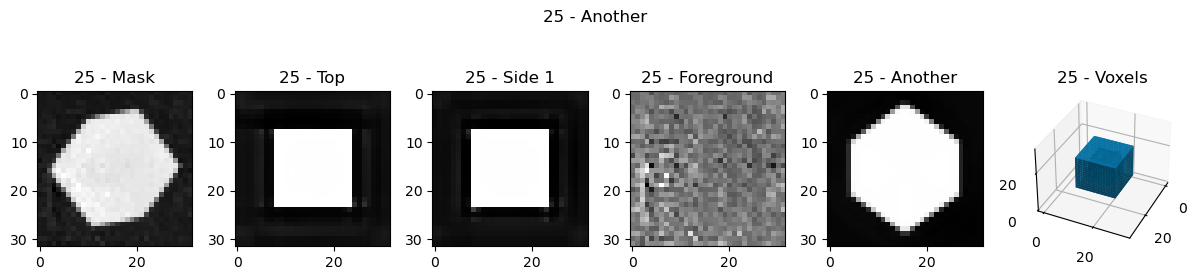

In [52]:
START_MODEL = 25
END_MODEL = 25

models = list(range(START_MODEL, END_MODEL + 1, bookmark_interval))

vox_gen_0_noise.eval()
mask_gen_0_noise.eval()
mask_gen_0_noise.to(DEVICE)

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for model_n in models:
    gan_trainer_0_noise.load_state(f"{model_path}_{model_n}.pt")
    
    mask_out = mask_gen_0_noise(gen_input)[0]

    mask = metaimage.Mask(
        mask_out, title=f"{model_n} - Mask"
    )
    
    fg_out = mask_gen_0_noise.foreground_gen(gen_input)[0]
    
    fg_out = fg_out.detach().cpu().numpy()
    
    fg_out = np.zeros((32, 32)) + fg_out[0, :, :] * fg_out[1, :, :]
    
    fg = metaimage.Mask(
        fg_out, title=f"{model_n} - Foreground"
    )
    
    voxels = voxgrid.VoxGrid(
        vox_gen_0_noise(gen_input)[0], title=f"{model_n} - Voxels"
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_image()),
            (f"{model_n} - Side 1", voxels.rotated(y_angle=np.pi / 2).create_image()),
            fg,
            # (f"{model_n} - Side 2", voxels.rotated(z_angle=np.pi / 2).create_image()),
            (f"{model_n} - Another", voxels.rotated(z_angle=np.pi / 4, y_angle=np.pi/4).create_image()),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(12, 3 * len(plot_grid)))
display.show()

Model models/cube_gan_25.pt is loaded from epoch 25 , loss 0.6316


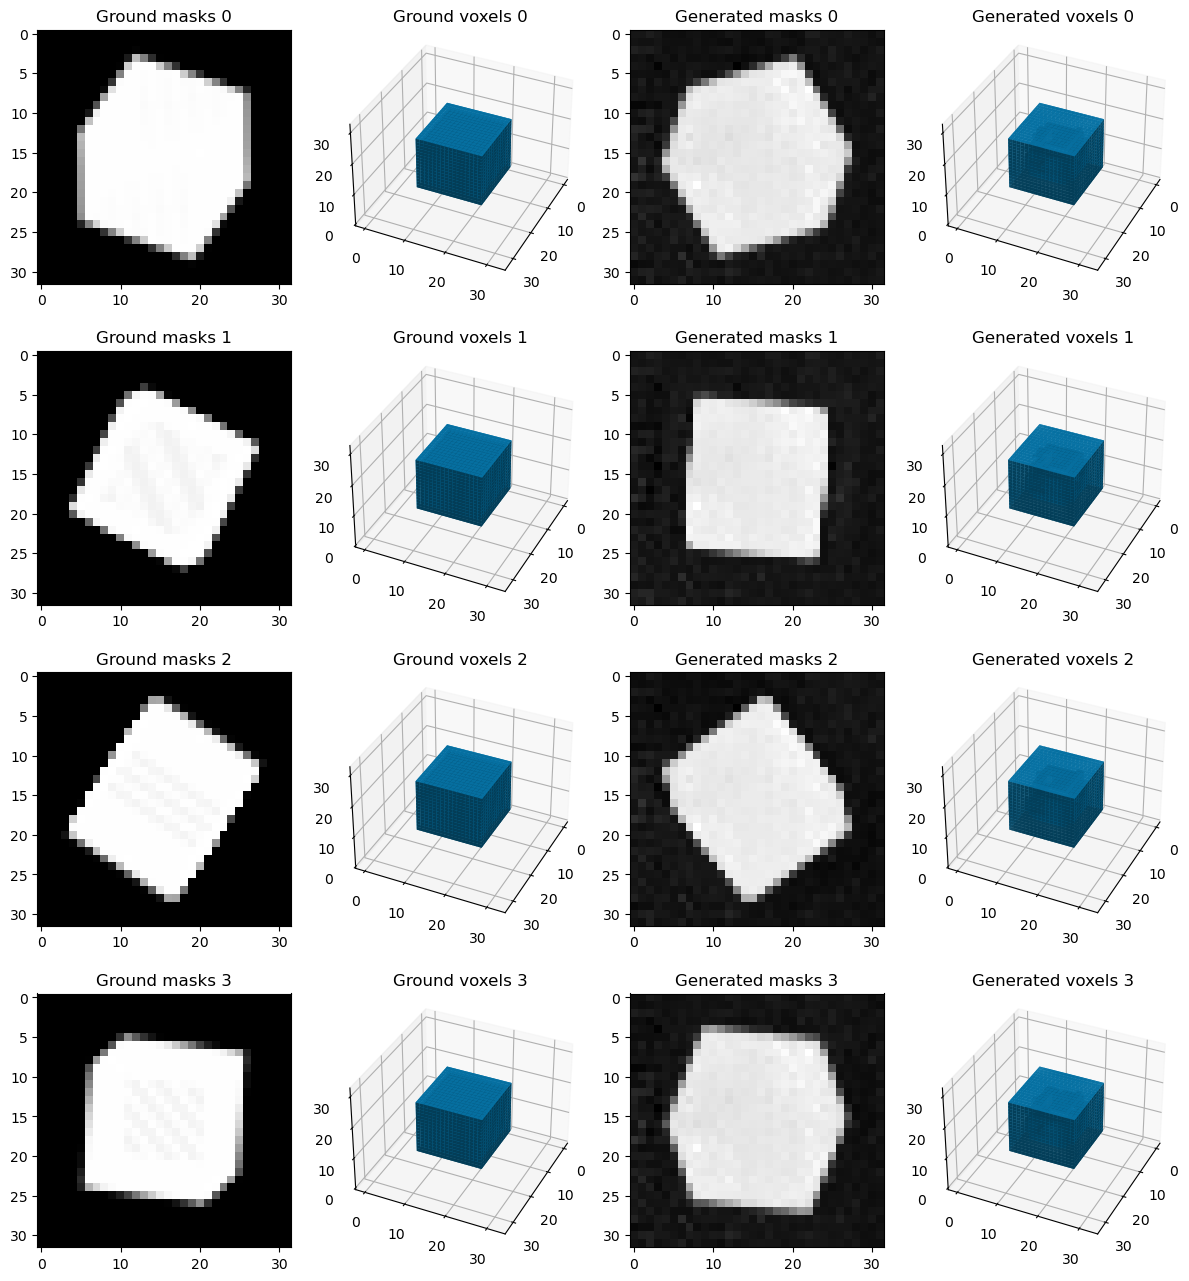

In [53]:
MODEL = 25

gan_trainer_0_noise.load_state(f"{model_path}_{MODEL}.pt")

gen_input = torch.Tensor(np.random.normal(0, 1, size=(4, LATENT_SIZE))).cuda()

masks = mask_gen_0_noise(gen_input)[:4]
voxels = vox_gen_0_noise(gen_input)[:4]

plot_grid = []

for i in range(4):
    cur_voxels = voxgrid.VoxGrid(voxels[i], title=f"Generated voxels {i}")
    cur_mask = metaimage.Mask(masks[i], title=f"Generated masks {i}")
    ground_mask, ground_voxels = train_dataset_0_noise[i][1]
    ground_mask = metaimage.Mask(ground_mask, title=f"Ground masks {i}")
    ground_voxels = voxgrid.VoxGrid(
        ground_voxels, title=f"Ground voxels {i}"
    )

    plot_grid.append([ground_mask, ground_voxels, cur_mask, cur_voxels])

display.grid(plot_grid, figsize=(12, 13))
display.show()

## Noise

The following tests how resilient the method is to adding salt and pepper noise to the training data.

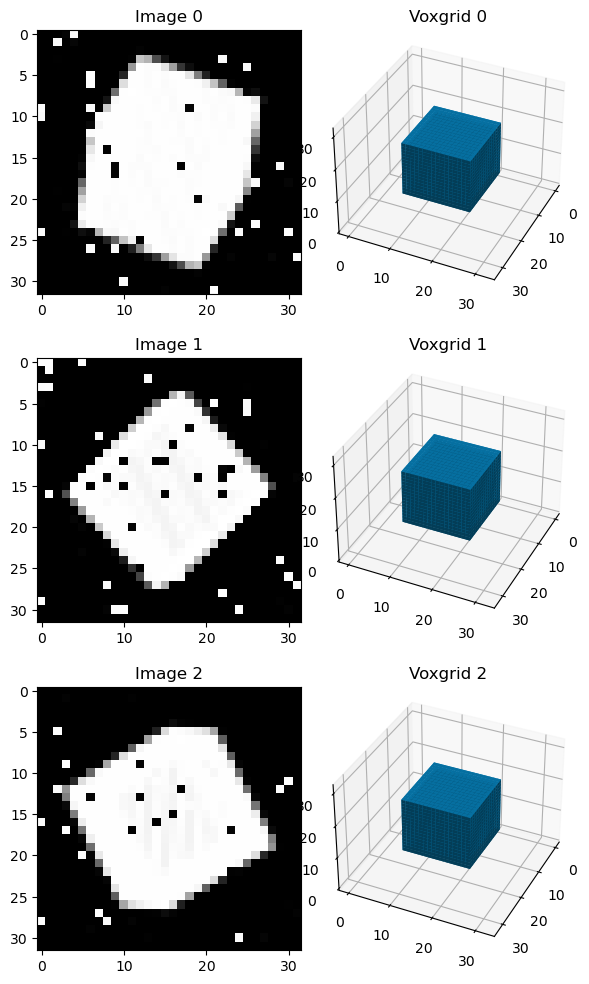

In [8]:

train_dataset_5_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 1000, train=True, noise=0.05)
val_dataset_5_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 100, noise=0.05)

train_loader_5_noise = torch.utils.data.DataLoader(
    train_dataset_5_noise, batch_size=BATCH_SIZE, shuffle=True
)
val_loader_5_noise = torch.utils.data.DataLoader(val_dataset_5_noise, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            metaimage.Mask(train_dataset_5_noise[i][0], title=f"Image {i}"),
            voxgrid.VoxGrid(train_dataset_5_noise[i][1][1], title=f"Voxgrid {i}"),
        ]
        for i in range(3)
    ],
    figsize=(6, 10),
)
display.show()

In [54]:
vox_gen_5_noise, mask_gen_5_noise, discriminator_5_noise = create_nnets()

gan_trainer_5_noise = nnet.training.GANTrainer(
    mask_gen_5_noise,
    discriminator_5_noise,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

model_path = "models/cube_gan_5_noise"
bookmark_interval = 25

In [55]:
gan_trainer_5_noise.train(
    train_loader_5_noise,
    val_loader_5_noise,
    epochs=50,
    path=model_path,
    noise=0.15,
    gen_train_thresh=1.5,
    dis_train_thresh=1.25,
    device=DEVICE,
    bookmark_every=bookmark_interval,
)

Epoch 50/50 | val loss (gen/dis): 0.8586/1.8157 | train loss: 0.86(48)/1.24(50): 100%|██████████| 50/50 [03:29<00:00,  4.18s/it]


Model models/cube_gan_5_noise_25.pt is loaded from epoch 25 , loss 1.0075
Model models/cube_gan_5_noise_50.pt is loaded from epoch 50 , loss 0.8586


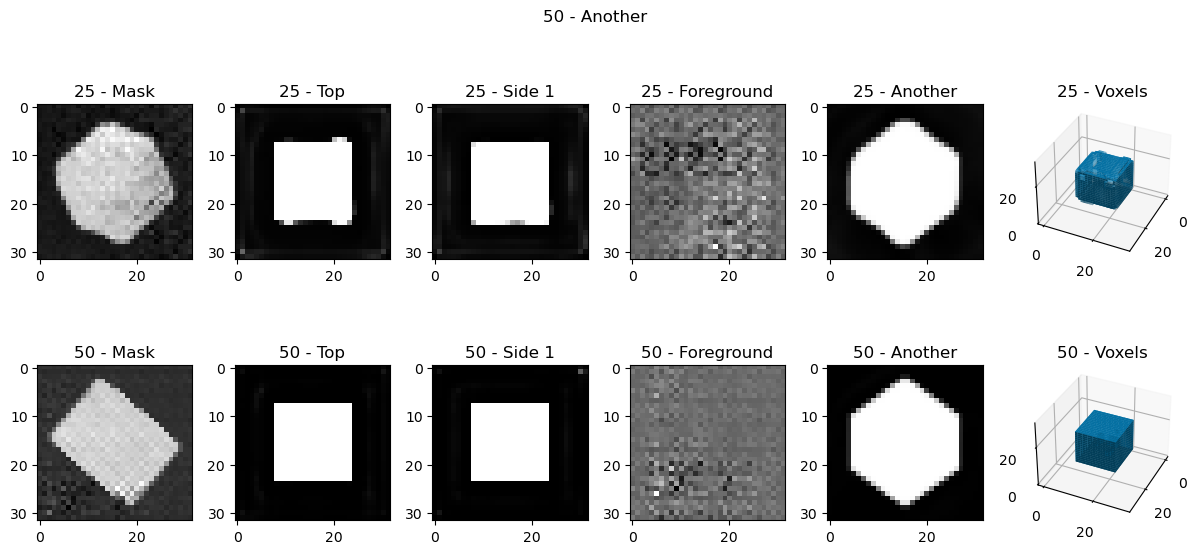

In [57]:
START_MODEL = 25
END_MODEL = 50

models = list(range(START_MODEL, END_MODEL + 1, bookmark_interval))

vox_gen_5_noise.eval()
mask_gen_5_noise.eval()
mask_gen_5_noise.to(DEVICE)

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for model_n in models:
    gan_trainer_5_noise.load_state(f"{model_path}_{model_n}.pt")
    
    mask_out = mask_gen_5_noise(gen_input)[0]

    mask = metaimage.Mask(
        mask_out, title=f"{model_n} - Mask"
    )
    
    fg_out = mask_gen_5_noise.foreground_gen(gen_input)[0]

    fg_out = fg_out.detach().cpu().numpy()
    
    fg_out = np.zeros((32, 32)) + fg_out[0, :, :] * fg_out[1, :, :]
    
    fg = metaimage.Mask(
        fg_out, title=f"{model_n} - Foreground"
    )
    
    voxels = voxgrid.VoxGrid(
        vox_gen_5_noise(gen_input)[0], title=f"{model_n} - Voxels"
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_image()),
            (f"{model_n} - Side 1", voxels.rotated(y_angle=np.pi / 2).create_image()),
            fg,
            # (f"{model_n} - Side 2", voxels.rotated(z_angle=np.pi / 2).create_image()),
            (f"{model_n} - Another", voxels.rotated(z_angle=np.pi / 4, y_angle=np.pi/4).create_image()),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(12, 3 * len(plot_grid)))
display.show()

Model models/cube_gan_5_noise_100.pt is loaded from epoch 100 , loss 1.0041


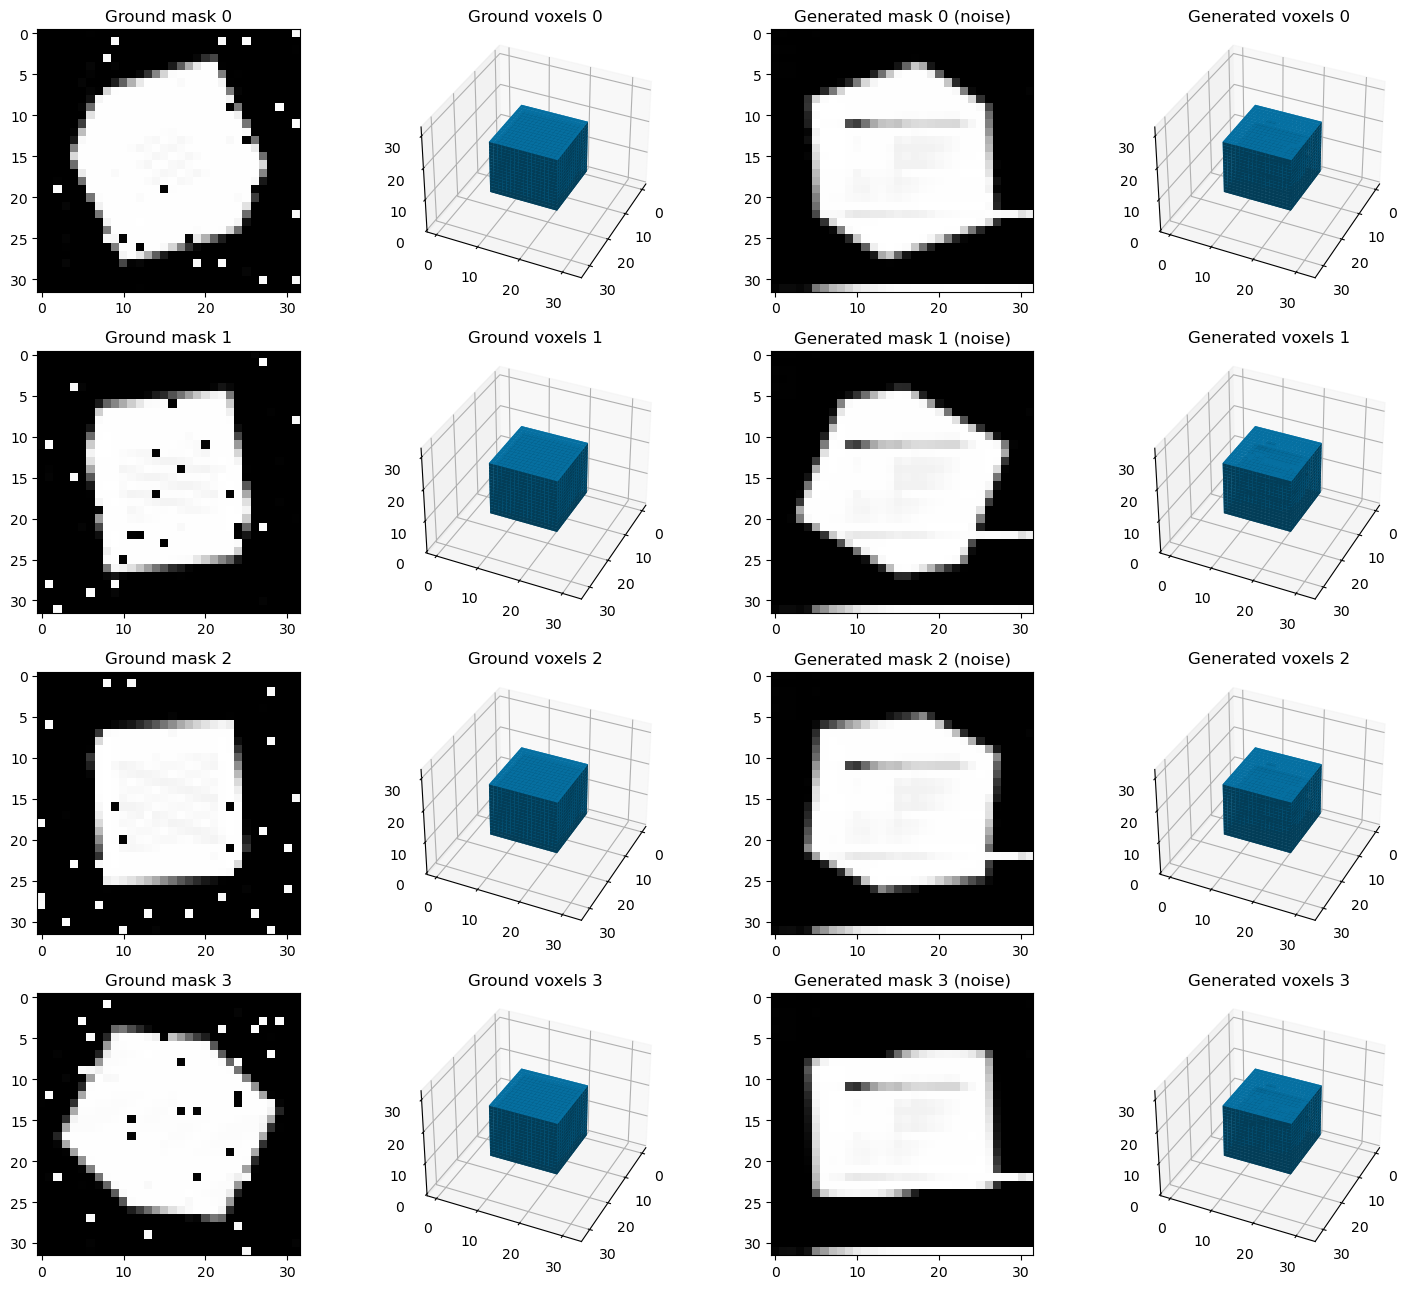

In [27]:
MODEL = 100

gan_trainer_5_noise.load_state(f"{model_path}_{MODEL}.pt")

gen_input = torch.Tensor(np.random.normal(0, 1, size=(4, LATENT_SIZE))).cuda()

masks = mask_gen_5_noise(gen_input)[:4]
voxels = vox_gen_5_noise(gen_input)[:4]

plot_grid = []

for i in range(4):
    cur_voxels = voxgrid.VoxGrid(voxels[i], title=f"Generated voxels {i}")
    rot_mask = cur_voxels.rotated(*np.random.uniform(0, np.pi*2, size=3)).create_image()
    rot_mask.title = f"Generated mask {i} (no noise)"
    cur_mask = metaimage.Mask(masks[i], title=f"Generated mask {i} (noise)")
    ground_mask, ground_voxels = train_dataset_5_noise[i][1]
    ground_mask = metaimage.Mask(ground_mask, title=f"Ground mask {i}")
    ground_voxels = voxgrid.VoxGrid(
        ground_voxels, title=f"Ground voxels {i}"
    )

    plot_grid.append([ground_mask, ground_voxels, cur_mask, cur_voxels])

display.grid(plot_grid, figsize=(15, 13))
display.show()

### 15% noise

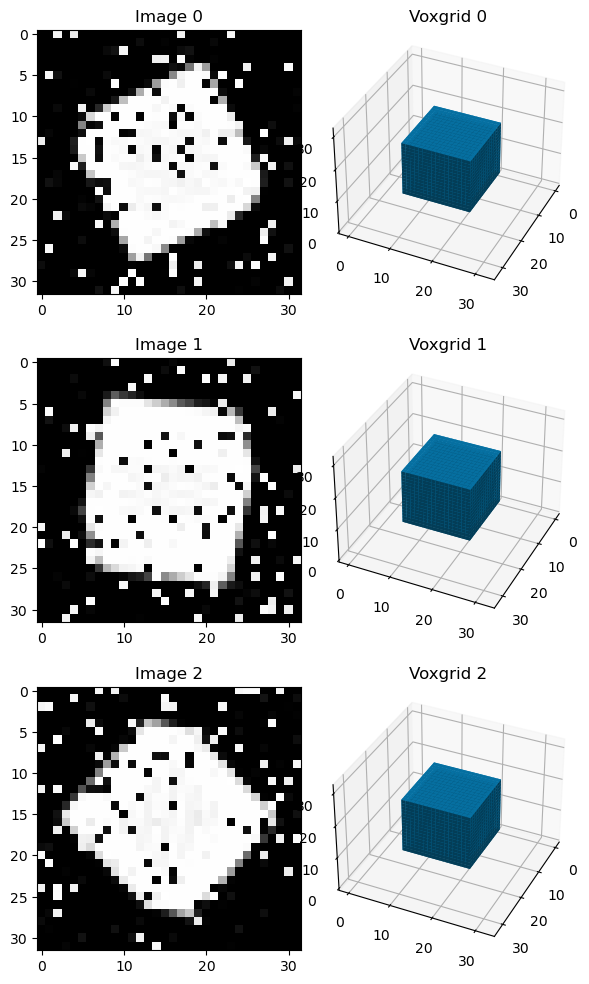

In [12]:

train_dataset_15_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 1000, train=True, noise=0.15)
val_dataset_15_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 100, noise=0.15)

train_loader_15_noise = torch.utils.data.DataLoader(
    train_dataset_15_noise, batch_size=BATCH_SIZE, shuffle=True
)
val_loader_15_noise = torch.utils.data.DataLoader(val_dataset_15_noise, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            metaimage.Mask(train_dataset_15_noise[i][0], title=f"Image {i}"),
            voxgrid.VoxGrid(train_dataset_15_noise[i][1][1], title=f"Voxgrid {i}"),
        ]
        for i in range(3)
    ],
    figsize=(6, 10),
)
display.show()

In [36]:
vox_gen_15_noise, mask_gen_15_noise, discriminator_15_noise = create_nnets()

gan_trainer_15_noise = nnet.training.GANTrainer(
    mask_gen_15_noise,
    discriminator_15_noise,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

model_path = "models/cube_gan_15_noise"
bookmark_interval = 50

In [37]:
gan_trainer_15_noise.train(
    train_loader_15_noise,
    val_loader_15_noise,
    epochs=100,
    path=model_path,
    noise=0.15,
    gen_train_thresh=1.5,
    dis_train_thresh=1.25,
    device=DEVICE,
    bookmark_every=bookmark_interval,
)

Epoch 100/100 | val loss (gen/dis): 0.9068/1.1659 | train loss: 1.15(99)/1.22(94): 100%|██████████| 100/100 [07:27<00:00,  4.47s/it]


Model models/cube_gan_15_noise_50.pt is loaded from epoch 50 , loss 0.4646
Model models/cube_gan_15_noise_100.pt is loaded from epoch 100 , loss 0.9068


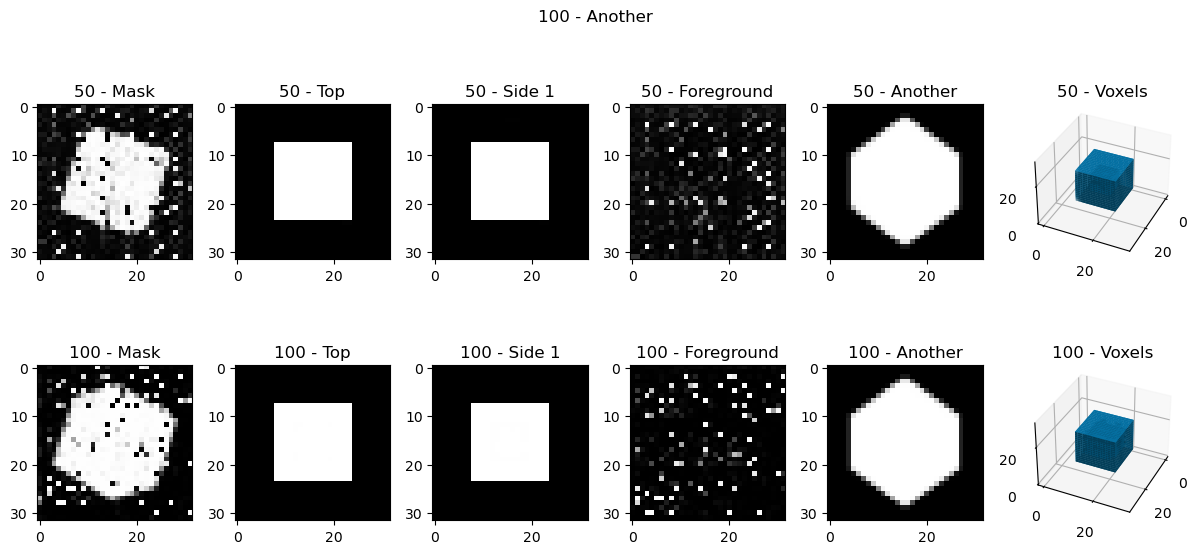

In [38]:
START_MODEL = 50
END_MODEL = 100

models = list(range(START_MODEL, END_MODEL + 1, bookmark_interval))

vox_gen_15_noise.eval()
mask_gen_15_noise.eval()
mask_gen_15_noise.to(DEVICE)

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for model_n in models:
    gan_trainer_15_noise.load_state(f"{model_path}_{model_n}.pt")
    
    mask_out = mask_gen_15_noise(gen_input)[0]

    mask = metaimage.Mask(
        mask_out, title=f"{model_n} - Mask"
    )
    
    fg_out = mask_gen_15_noise.foreground_gen(gen_input)[0]

    fg_out = fg_out.detach().cpu().numpy()
    
    fg_out = np.zeros((32, 32)) + fg_out[0, :, :] * fg_out[1, :, :]
    
    fg = metaimage.Mask(
        fg_out, title=f"{model_n} - Foreground"
    )
    
    voxels = voxgrid.VoxGrid(
        vox_gen_15_noise(gen_input)[0], title=f"{model_n} - Voxels"
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_image()),
            (f"{model_n} - Side 1", voxels.rotated(y_angle=np.pi / 2).create_image()),
            fg,
            # (f"{model_n} - Side 2", voxels.rotated(z_angle=np.pi / 2).create_image()),
            (f"{model_n} - Another", voxels.rotated(z_angle=np.pi / 4, y_angle=np.pi/4).create_image()),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(12, 3 * len(plot_grid)))
display.show()

Model models/cube_gan_15_noise_100.pt is loaded from epoch 100 , loss 0.9068


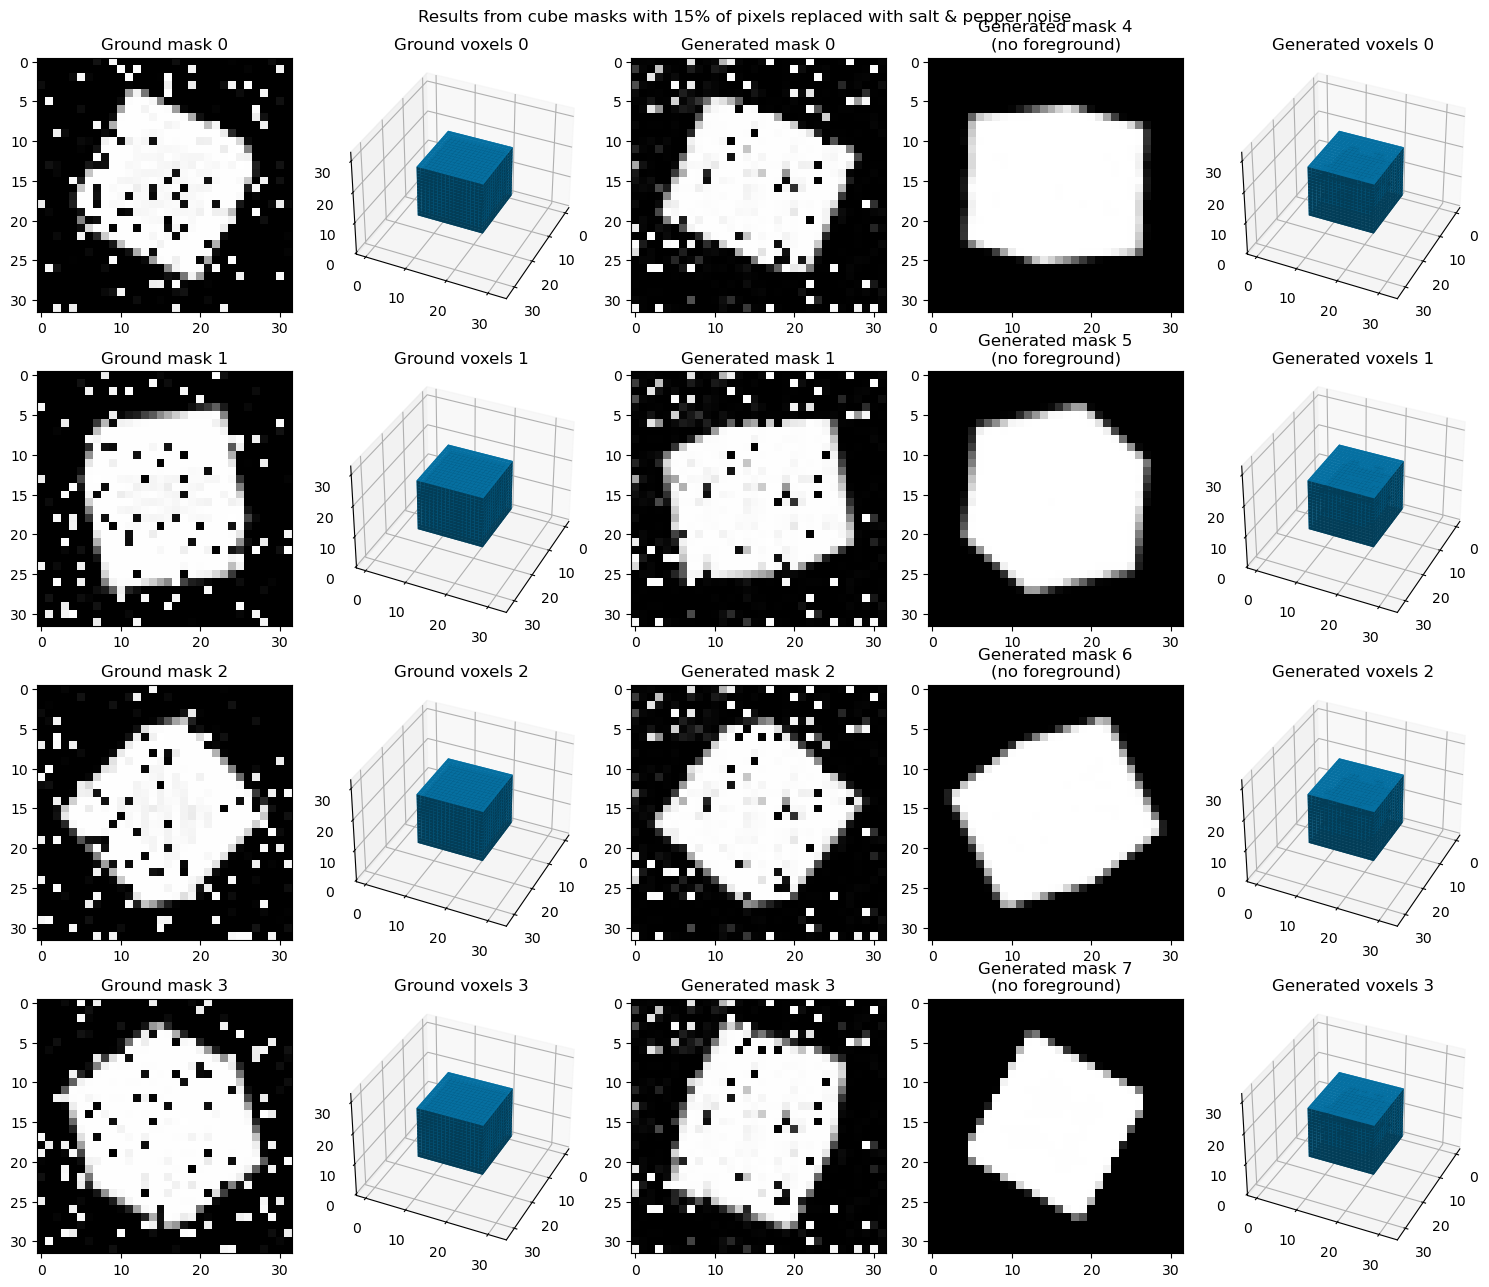

In [39]:
MODEL = 100

gan_trainer_15_noise.load_state(f"{model_path}_{MODEL}.pt")

gen_input = torch.Tensor(np.random.normal(0, 1, size=(4, LATENT_SIZE))).cuda()

masks = mask_gen_15_noise(gen_input)[:4]
voxels = vox_gen_15_noise(gen_input)[:4]

plot_grid = []

for i in range(4):
    cur_voxels = voxgrid.VoxGrid(voxels[i], title=f"Generated voxels {i}")
    rot_mask = cur_voxels.rotated(*np.random.uniform(0, np.pi*2, size=3)).create_image()
    rot_mask.title = f"Generated mask {i+4}\n(no foreground)"
    cur_mask = metaimage.Mask(masks[i], title=f"Generated mask {i}")
    ground_mask, ground_voxels = train_dataset_15_noise[i][1]
    ground_mask = metaimage.Mask(ground_mask, title=f"Ground mask {i}")
    ground_voxels = voxgrid.VoxGrid(
        ground_voxels, title=f"Ground voxels {i}"
    )

    plot_grid.append([ground_mask, ground_voxels, cur_mask, rot_mask, cur_voxels])

display.grid(plot_grid, figsize=(15, 13), title="Results from cube masks with 15% of pixels replaced with salt & pepper noise")
display.show()

### 30% noise

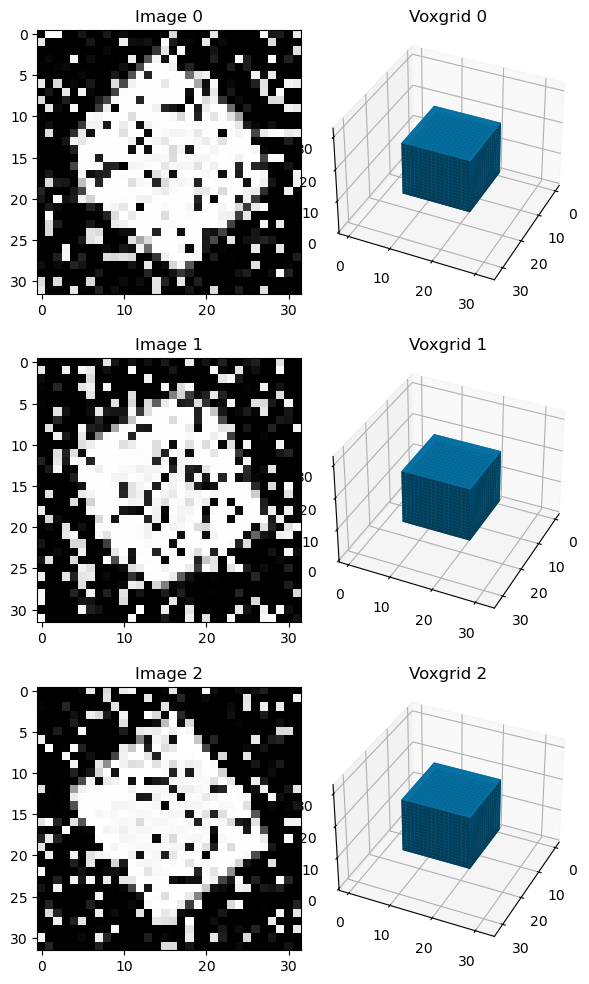

In [40]:

train_dataset_30_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 1000, train=True, noise=0.30)
val_dataset_30_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 100, noise=0.30)

train_loader_30_noise = torch.utils.data.DataLoader(
    train_dataset_30_noise, batch_size=BATCH_SIZE, shuffle=True
)
val_loader_30_noise = torch.utils.data.DataLoader(val_dataset_30_noise, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            metaimage.Mask(train_dataset_30_noise[i][0], title=f"Image {i}"),
            voxgrid.VoxGrid(train_dataset_30_noise[i][1][1], title=f"Voxgrid {i}"),
        ]
        for i in range(3)
    ],
    figsize=(6, 10),
)
display.show()

In [41]:
vox_gen_30_noise, mask_gen_30_noise, discriminator_30_noise = create_nnets()

gan_trainer_30_noise = nnet.training.GANTrainer(
    mask_gen_30_noise,
    discriminator_30_noise,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

model_path = "models/cube_gan_30_noise"
bookmark_interval = 25

In [42]:
gan_trainer_30_noise.train(
    train_loader_30_noise,
    val_loader_30_noise,
    epochs=100,
    path=model_path,
    noise=0.15,
    gen_train_thresh=1.5,
    dis_train_thresh=1.25,
    device=DEVICE,
    bookmark_every=bookmark_interval,
)

Epoch 100/100 | val loss (gen/dis): 0.9525/1.7697 | train loss: 1.75(98)/1.07(86): 100%|██████████| 100/100 [07:25<00:00,  4.45s/it]


Model models/cube_gan_30_noise_25.pt is loaded from epoch 25 , loss 0.7200
Model models/cube_gan_30_noise_50.pt is loaded from epoch 50 , loss 0.9376
Model models/cube_gan_30_noise_75.pt is loaded from epoch 75 , loss 0.7956
Model models/cube_gan_30_noise_100.pt is loaded from epoch 100 , loss 0.9525


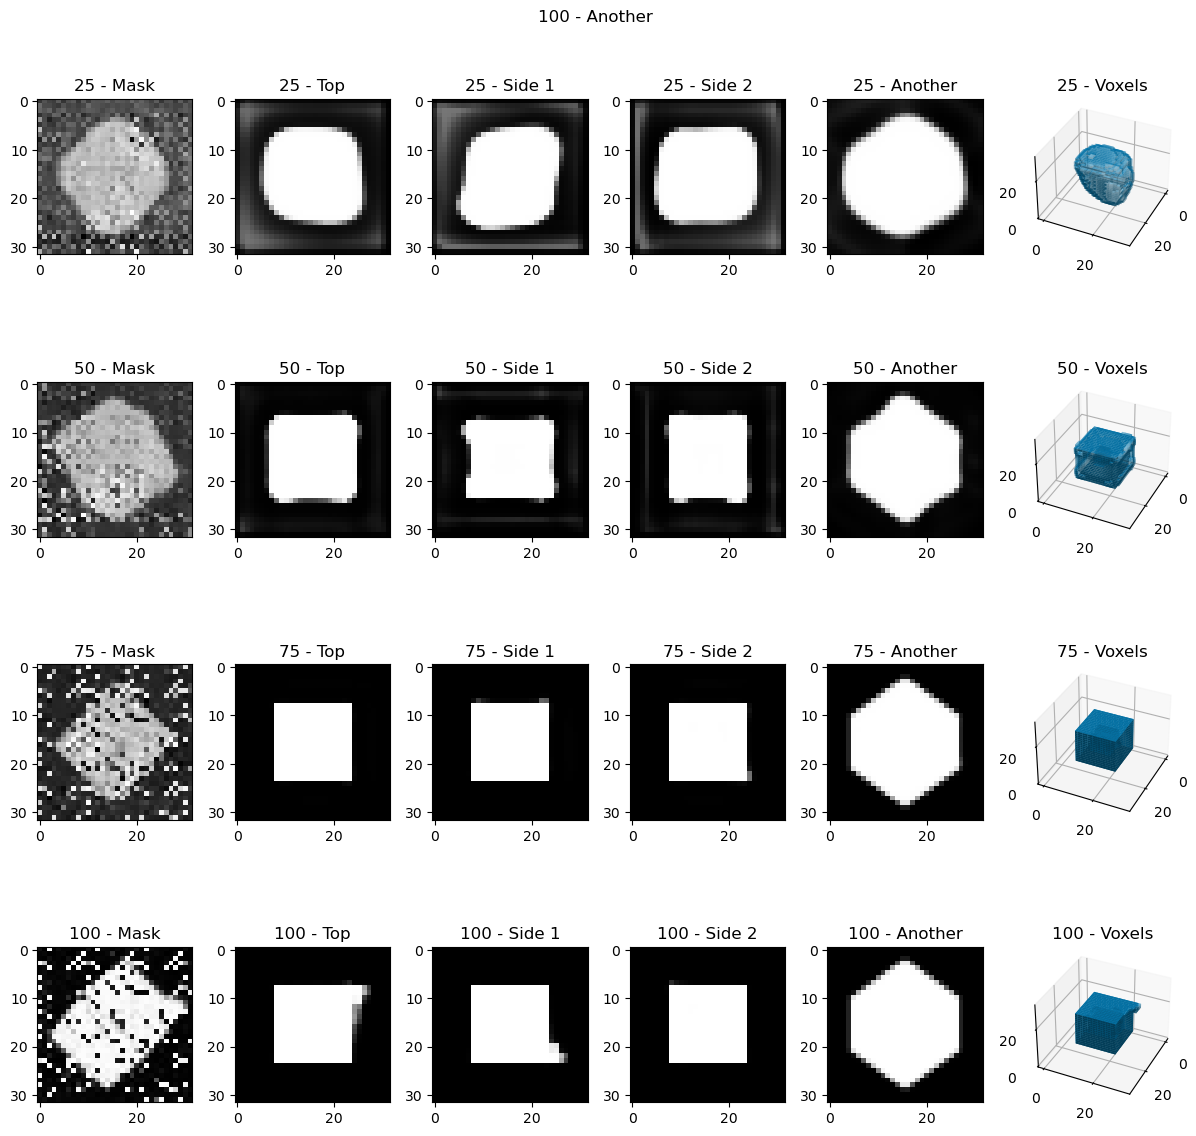

In [43]:
START_MODEL = 25
END_MODEL = 100

model_path = "models/cube_gan_30_noise"

models = list(range(START_MODEL, END_MODEL + 1, bookmark_interval))

vox_gen_30_noise.eval()
mask_gen_30_noise.eval()
mask_gen_30_noise.to(DEVICE)

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for model_n in models:
    gan_trainer_30_noise.load_state(f"{model_path}_{model_n}.pt")
    
    mask_out = mask_gen_30_noise(gen_input)[0]

    mask = metaimage.Mask(
        mask_out, title=f"{model_n} - Mask"
    )
    voxels = voxgrid.VoxGrid(
        vox_gen_30_noise(gen_input)[0], title=f"{model_n} - Voxels"
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_image()),
            (f"{model_n} - Side 1", voxels.rotated(y_angle=np.pi / 2).create_image()),
            (f"{model_n} - Side 2", voxels.rotated(z_angle=np.pi / 2).create_image()),
            (f"{model_n} - Another", voxels.rotated(z_angle=np.pi / 4, y_angle=np.pi/4).create_image()),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(12, 3 * len(plot_grid)))
display.show()

### 50% Noise

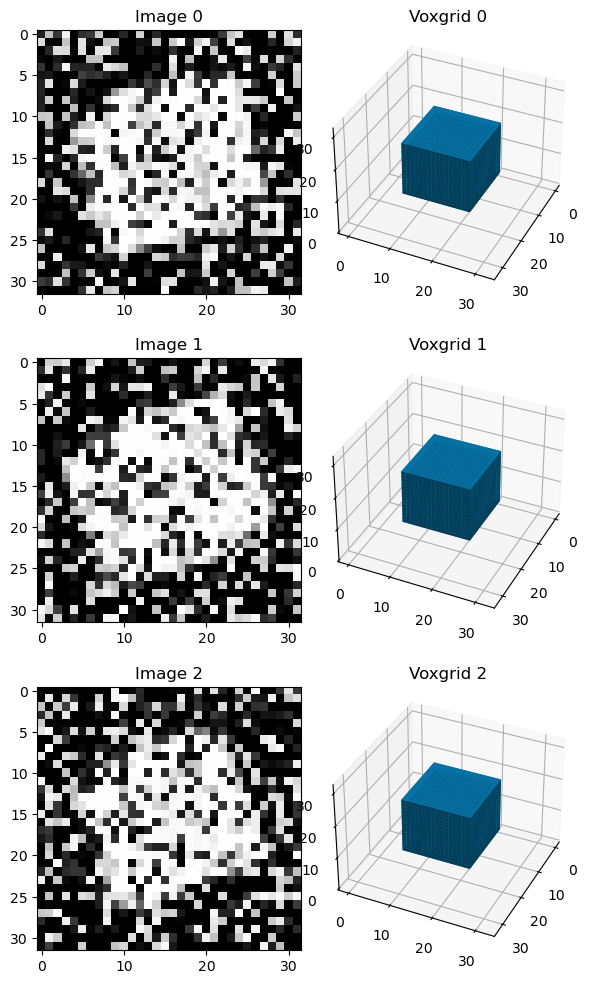

In [44]:

train_dataset_50_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 1000, train=True, noise=0.50)
val_dataset_50_noise = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 100, noise=0.50)

train_loader_50_noise = torch.utils.data.DataLoader(
    train_dataset_50_noise, batch_size=BATCH_SIZE, shuffle=True
)
val_loader_50_noise = torch.utils.data.DataLoader(val_dataset_50_noise, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            metaimage.Mask(train_dataset_50_noise[i][0], title=f"Image {i}"),
            voxgrid.VoxGrid(train_dataset_50_noise[i][1][1], title=f"Voxgrid {i}"),
        ]
        for i in range(3)
    ],
    figsize=(6, 10),
)
display.show()

In [45]:
vox_gen_50_noise, mask_gen_50_noise, discriminator_50_noise = create_nnets()

gan_trainer_50_noise = nnet.training.GANTrainer(
    mask_gen_50_noise,
    discriminator_50_noise,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

model_path = "models/cube_gan_50_noise"
bookmark_interval = 25

In [48]:
gan_trainer_50_noise.train(
    train_loader_50_noise,
    val_loader_50_noise,
    epochs=50,
    path=model_path,
    noise=0.15,
    gen_train_thresh=1.5,
    dis_train_thresh=1.25,
    device=DEVICE,
    bookmark_every=bookmark_interval,
)

Epoch 150/150 | val loss (gen/dis): 1.0085/1.0423 | train loss: 1.39(50)/1.12(37): 100%|██████████| 50/50 [03:51<00:00,  4.63s/it]


Model models/cube_gan_50_noise_50.pt is loaded from epoch 50 , loss 0.7426
Model models/cube_gan_50_noise_75.pt is loaded from epoch 75 , loss 0.6219
Model models/cube_gan_50_noise_100.pt is loaded from epoch 100 , loss 0.5809
Model models/cube_gan_50_noise_125.pt is loaded from epoch 125 , loss 1.3802
Model models/cube_gan_50_noise_150.pt is loaded from epoch 150 , loss 1.0085


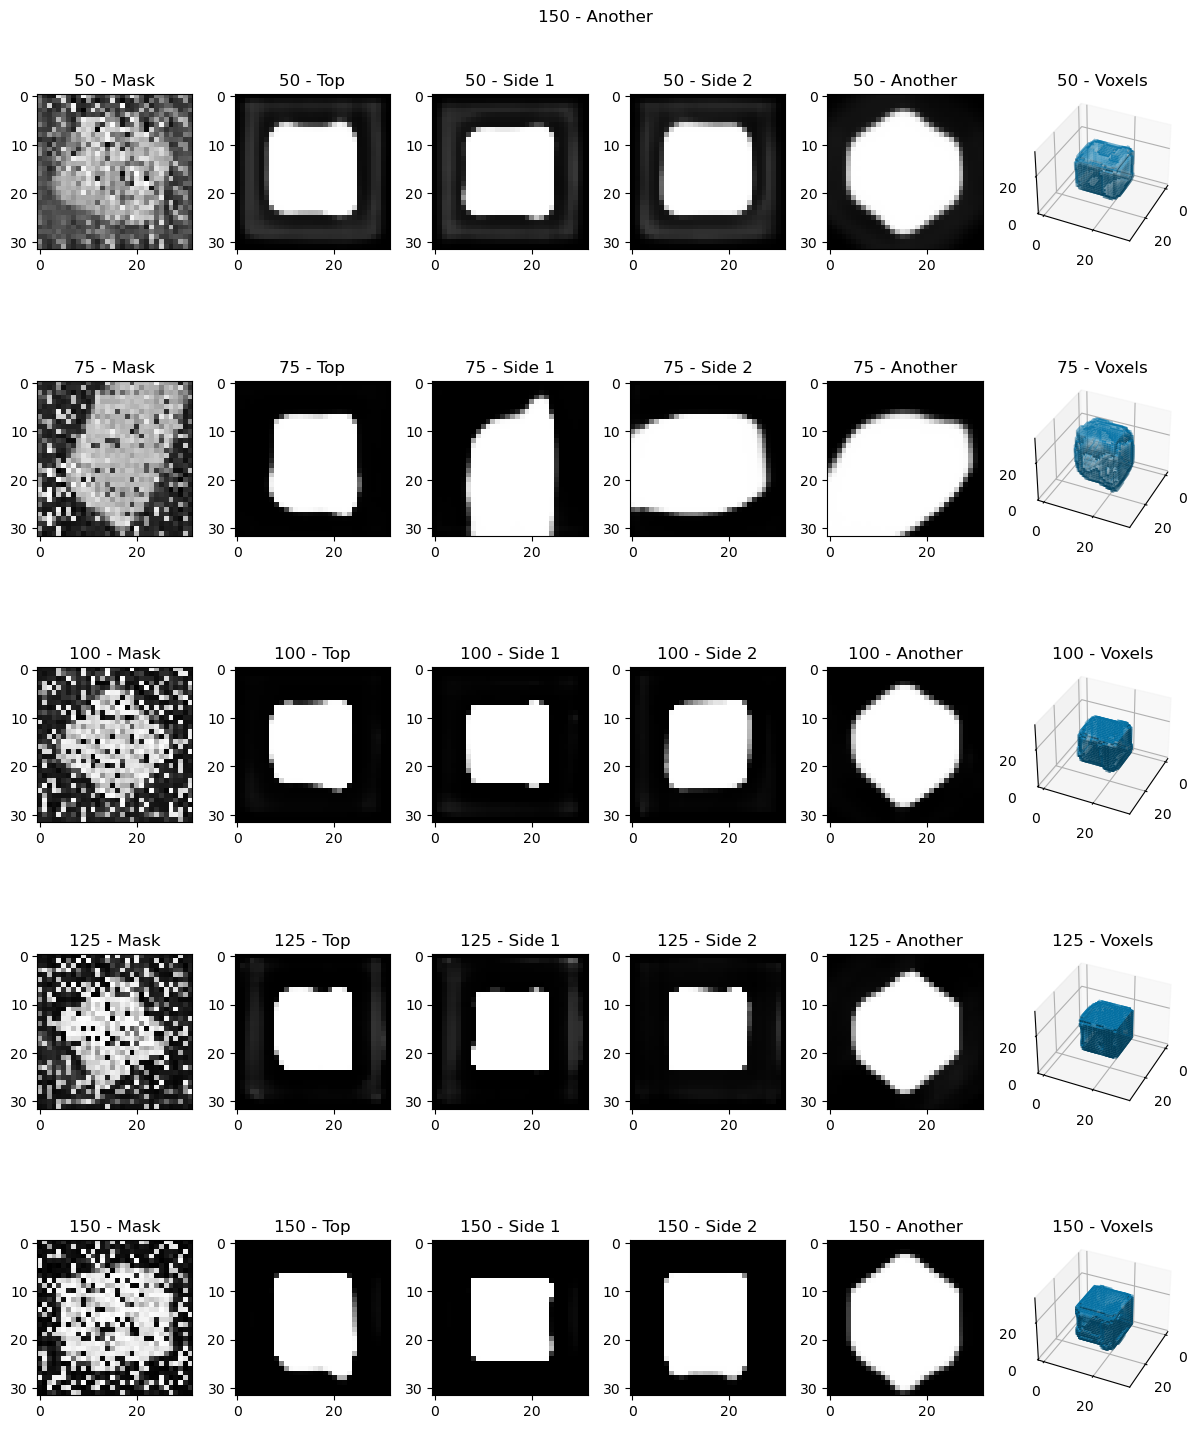

In [49]:
START_MODEL = 50
END_MODEL = 150

models = list(range(START_MODEL, END_MODEL + 1, bookmark_interval))

vox_gen_50_noise.eval()
mask_gen_50_noise.eval()
mask_gen_50_noise.to(DEVICE)

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for model_n in models:
    gan_trainer_50_noise.load_state(f"{model_path}_{model_n}.pt")
    
    mask_out = mask_gen_50_noise(gen_input)[0]

    mask = metaimage.Mask(
        mask_out, title=f"{model_n} - Mask"
    )
    voxels = voxgrid.VoxGrid(
        vox_gen_50_noise(gen_input)[0], title=f"{model_n} - Voxels"
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_image()),
            (f"{model_n} - Side 1", voxels.rotated(y_angle=np.pi / 2).create_image()),
            (f"{model_n} - Side 2", voxels.rotated(z_angle=np.pi / 2).create_image()),
            (f"{model_n} - Another", voxels.rotated(z_angle=np.pi / 4, y_angle=np.pi/4).create_image()),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(12, 3 * len(plot_grid)))
display.show()

### 20% occlusion

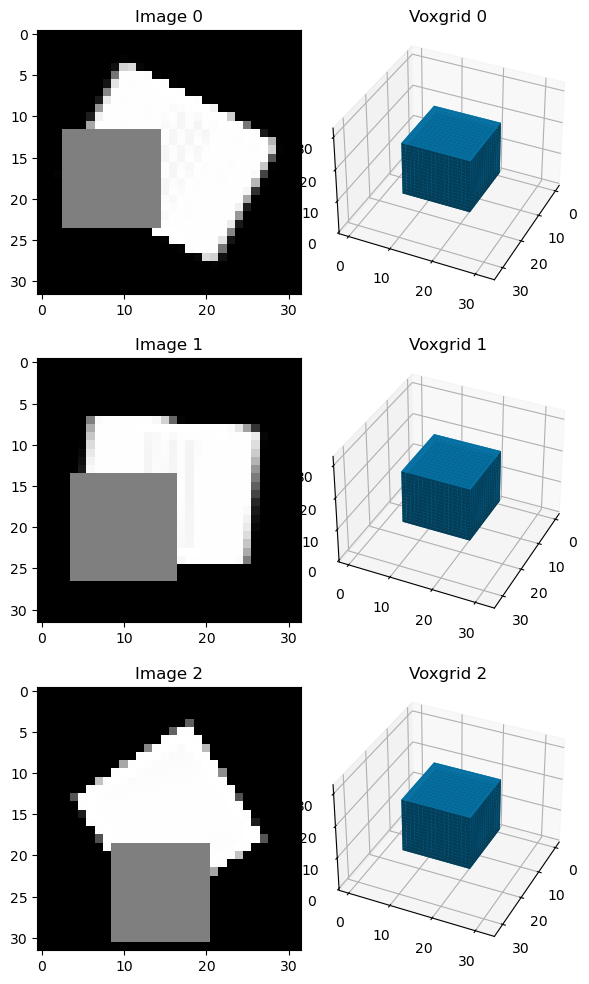

In [29]:

SIDE_RANGE = (16, 16)
IMAGE_SIZE = (32, 32)
SPACE_SIZE = (32, 32, 32)
BATCH_SIZE = 100

train_dataset_20_occ = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 1000, train=True, occlude=(0.15,0.25))
val_dataset_20_occ = datasets.synth.Cuboid(SIDE_RANGE, SPACE_SIZE, 100, occlude=(0.15,0.25))

train_loader_20_occ = torch.utils.data.DataLoader(
    train_dataset_20_occ, batch_size=BATCH_SIZE, shuffle=True
)
val_loader_20_occ = torch.utils.data.DataLoader(val_dataset_20_occ, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            metaimage.Mask(train_dataset_20_occ[i][0], title=f"Image {i}"),
            voxgrid.VoxGrid(train_dataset_20_occ[i][1][1], title=f"Voxgrid {i}"),
        ]
        for i in range(3)
    ],
    figsize=(6, 10),
)
display.show()

In [30]:
vox_gen_20_occ, mask_gen_20_occ, discriminator_20_occ = create_nnets()

gan_trainer_20_occ = nnet.training.GANTrainer(
    mask_gen_20_occ,
    discriminator_20_occ,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

model_path = "models/cube_gan_20_occ"
bookmark_interval = 25

In [36]:
gan_trainer_20_occ.train(
    train_loader_20_occ,
    val_loader_20_occ,
    epochs=50,
    path=model_path,
    noise=0.15,
    gen_train_thresh=1.5,
    dis_train_thresh=1.25,
    device=DEVICE,
    bookmark_every=bookmark_interval,
)

Epoch 150/150 | val loss (gen/dis): 1.2640/2.1056 | train loss: 1.07(49)/1.00(40): 100%|██████████| 50/50 [03:23<00:00,  4.07s/it]


Model models/cube_gan_20_occ_50.pt is loaded from epoch 50 , loss 1.8937
Model models/cube_gan_20_occ_75.pt is loaded from epoch 75 , loss 1.3906
Model models/cube_gan_20_occ_100.pt is loaded from epoch 100 , loss 1.8890
Model models/cube_gan_20_occ_125.pt is loaded from epoch 125 , loss 1.6613
Model models/cube_gan_20_occ_150.pt is loaded from epoch 150 , loss 1.2640


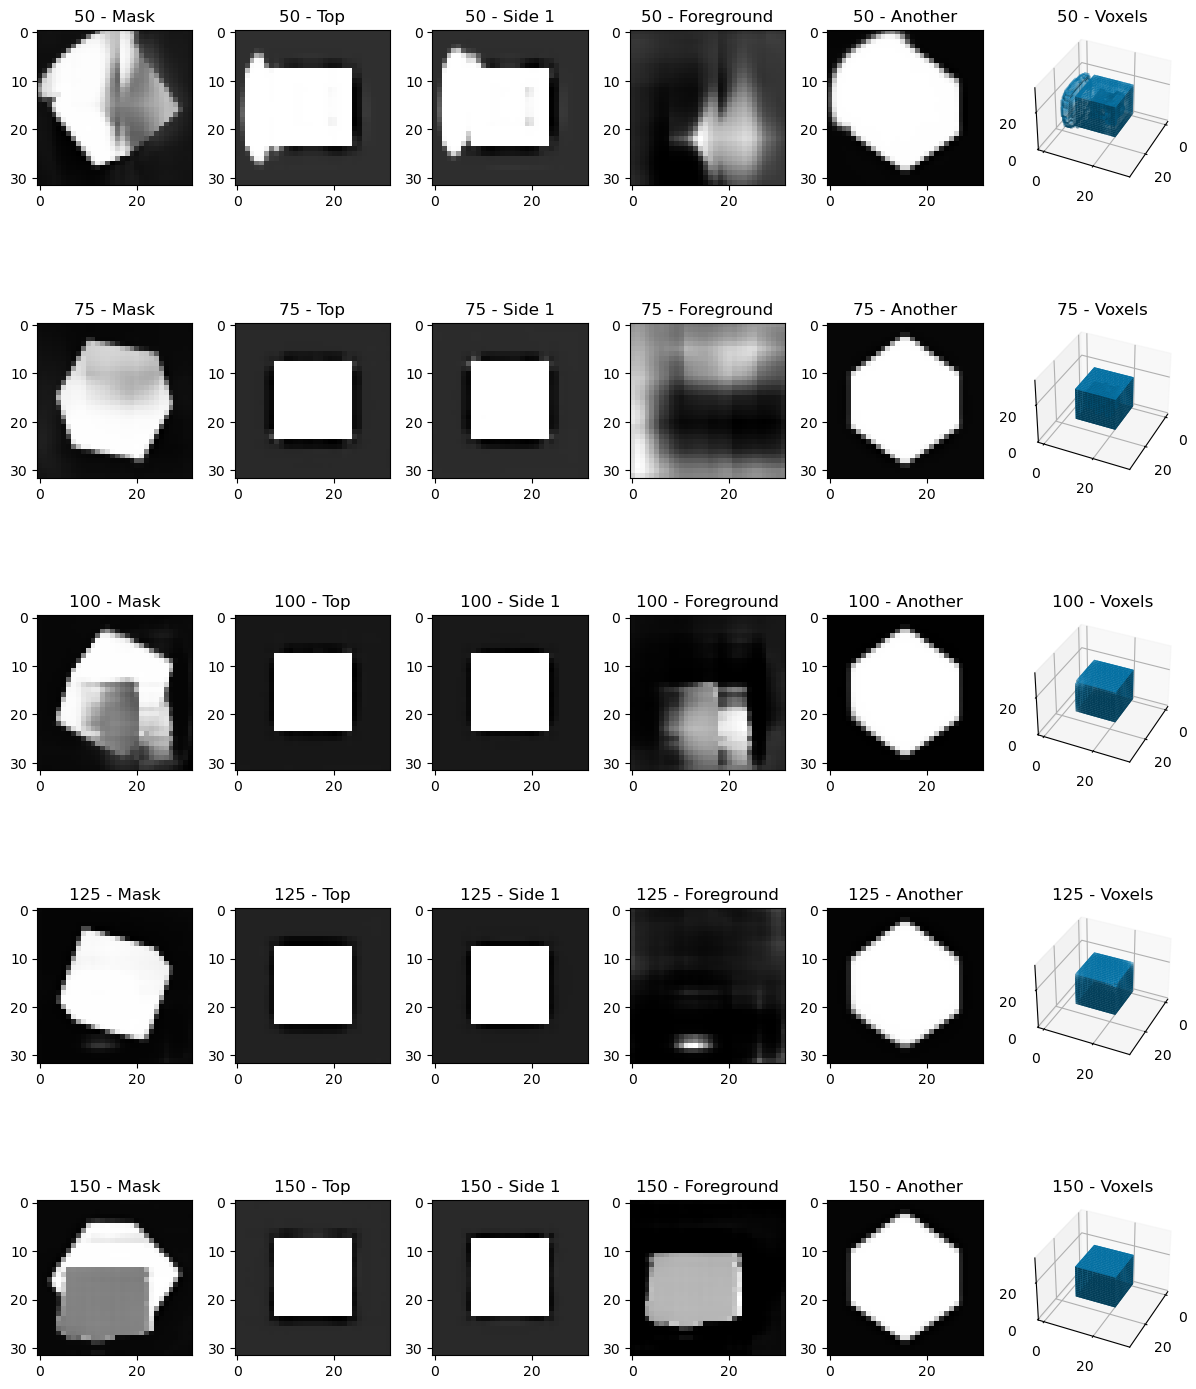

In [37]:
START_MODEL = 50
END_MODEL = 150

models = list(range(START_MODEL, END_MODEL + 1, bookmark_interval))

vox_gen_20_occ.eval()
mask_gen_20_occ.eval()
mask_gen_20_occ.to(DEVICE)

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for model_n in models:
    gan_trainer_20_occ.load_state(f"{model_path}_{model_n}.pt")
    
    mask_out = mask_gen_20_occ(gen_input)[0]

    mask = metaimage.Mask(
        mask_out, title=f"{model_n} - Mask"
    )
    
    fg_out = mask_gen_20_occ.foreground_gen(gen_input)[0]
    
    fg_out = fg_out.detach().cpu().numpy()
    
    fg_out = np.zeros((32, 32)) + fg_out[0, :, :] * fg_out[1, :, :]
    
    fg = metaimage.Mask(
        fg_out, title=f"{model_n} - Foreground"
    )
    
    voxels = voxgrid.VoxGrid(
        vox_gen_20_occ(gen_input)[0], title=f"{model_n} - Voxels"
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_image()),
            (f"{model_n} - Side 1", voxels.rotated(y_angle=np.pi / 2).create_image()),
            fg,
            # (f"{model_n} - Side 2", voxels.rotated(z_angle=np.pi / 2).create_image()),
            (f"{model_n} - Another", voxels.rotated(z_angle=np.pi / 4, y_angle=np.pi/4).create_image()),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(12, 3 * len(plot_grid)))
display.show()

Model models/cube_gan_20_occ_150.pt is loaded from epoch 150 , loss 1.2640


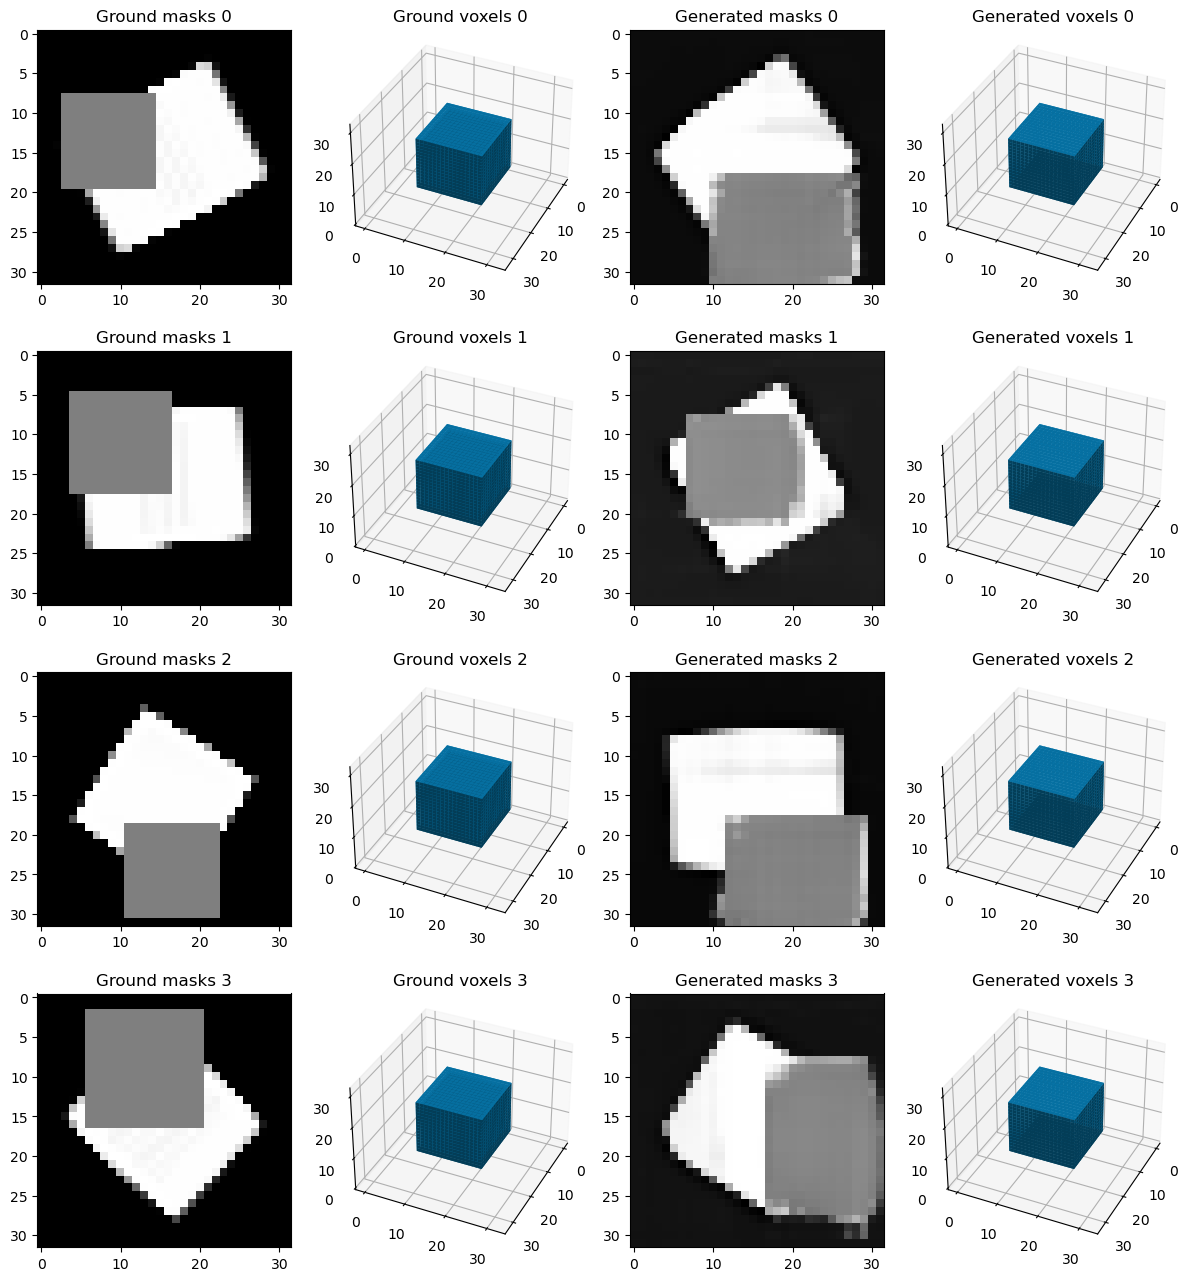

In [38]:
MODEL = 150

gan_trainer_20_occ.load_state(f"{model_path}_{MODEL}.pt")

gen_input = torch.Tensor(np.random.normal(0, 1, size=(4, LATENT_SIZE))).cuda()

masks = mask_gen_20_occ(gen_input)[:4]
voxels = vox_gen_20_occ(gen_input)[:4]

plot_grid = []

for i in range(4):
    cur_voxels = voxgrid.VoxGrid(voxels[i], title=f"Generated voxels {i}")
    cur_mask = metaimage.Mask(masks[i], title=f"Generated masks {i}")
    ground_mask, ground_voxels = train_dataset_20_occ[i][1]
    ground_mask = metaimage.Mask(ground_mask, title=f"Ground masks {i}")
    ground_voxels = voxgrid.VoxGrid(
        ground_voxels, title=f"Ground voxels {i}"
    )

    plot_grid.append([ground_mask, ground_voxels, cur_mask, cur_voxels])

display.grid(plot_grid, figsize=(12, 13))
display.show()